Otsu thresholds -> gray: 148.0, hue: 52.0
Poč. komponent: 14
Manual area thresholds: thr_2=3900, thr_5=4800, thr_10=5300
6217  10
4117  2
3900  2
4482  2
5100  5
4466  2
4626  2
4243  2
4338  2
4235  2
4170  2
5052  5
5442  10
3557  1
Počty mincí (klasifikace): {np.str_('10 Kc'): np.int64(2), np.str_('5 Kc'): np.int64(2), np.str_('2 Kc'): np.int64(9), np.str_('1 Kc'): np.int64(1)}


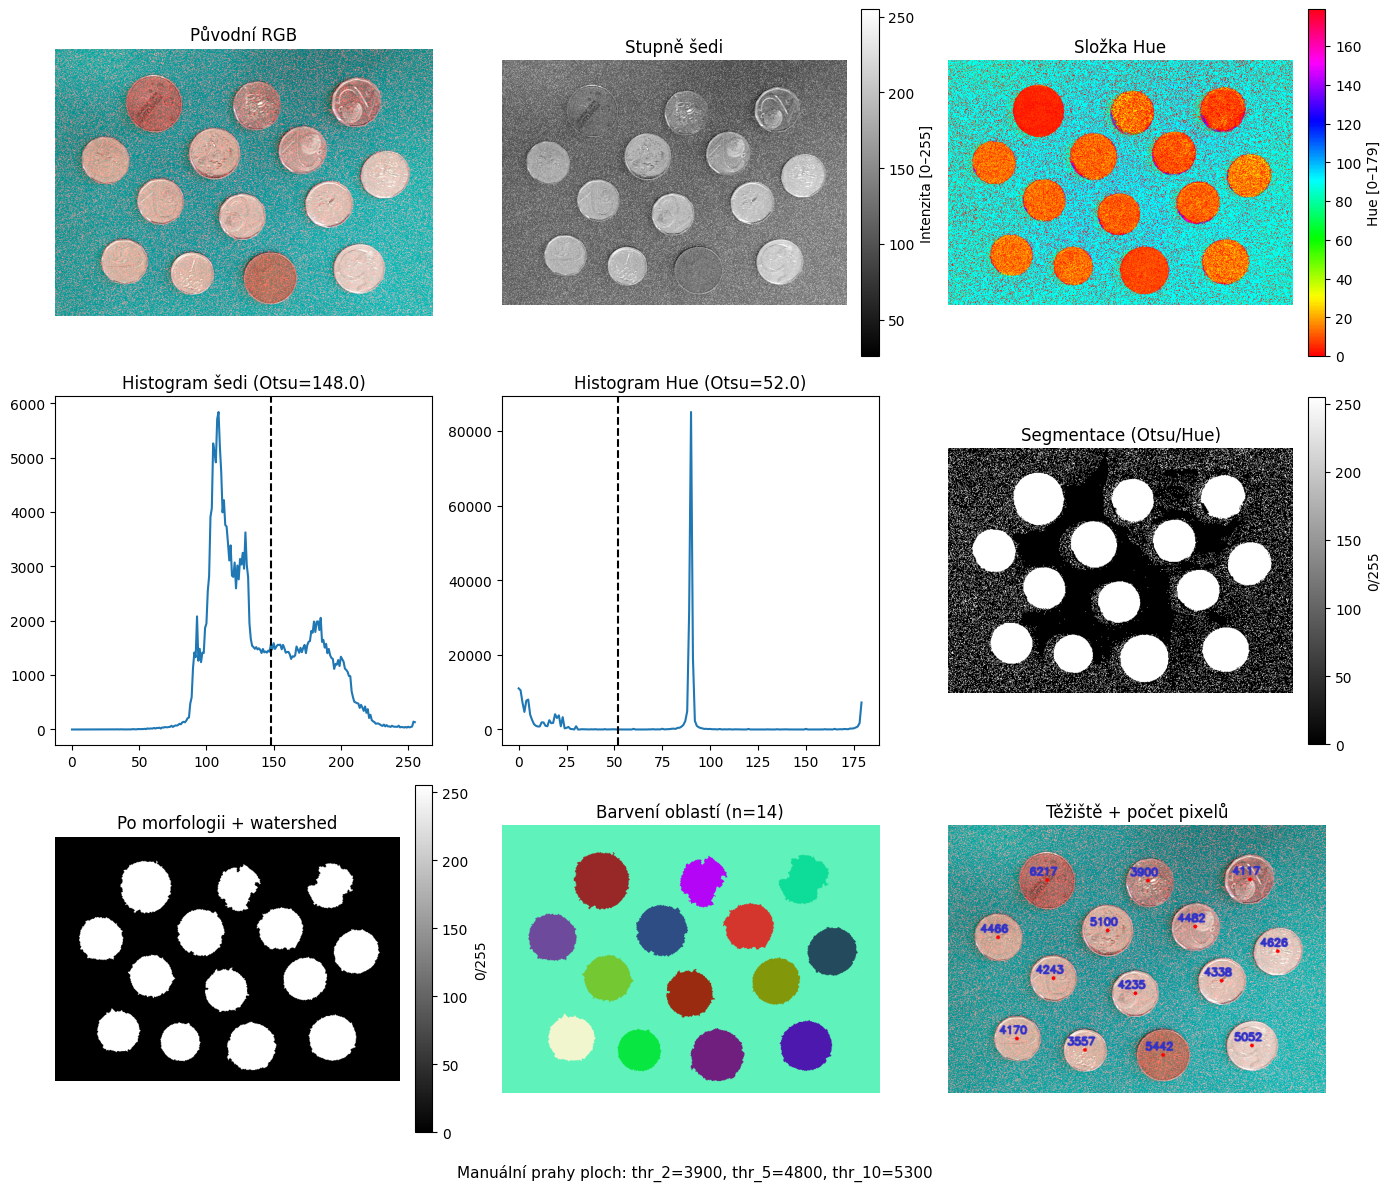

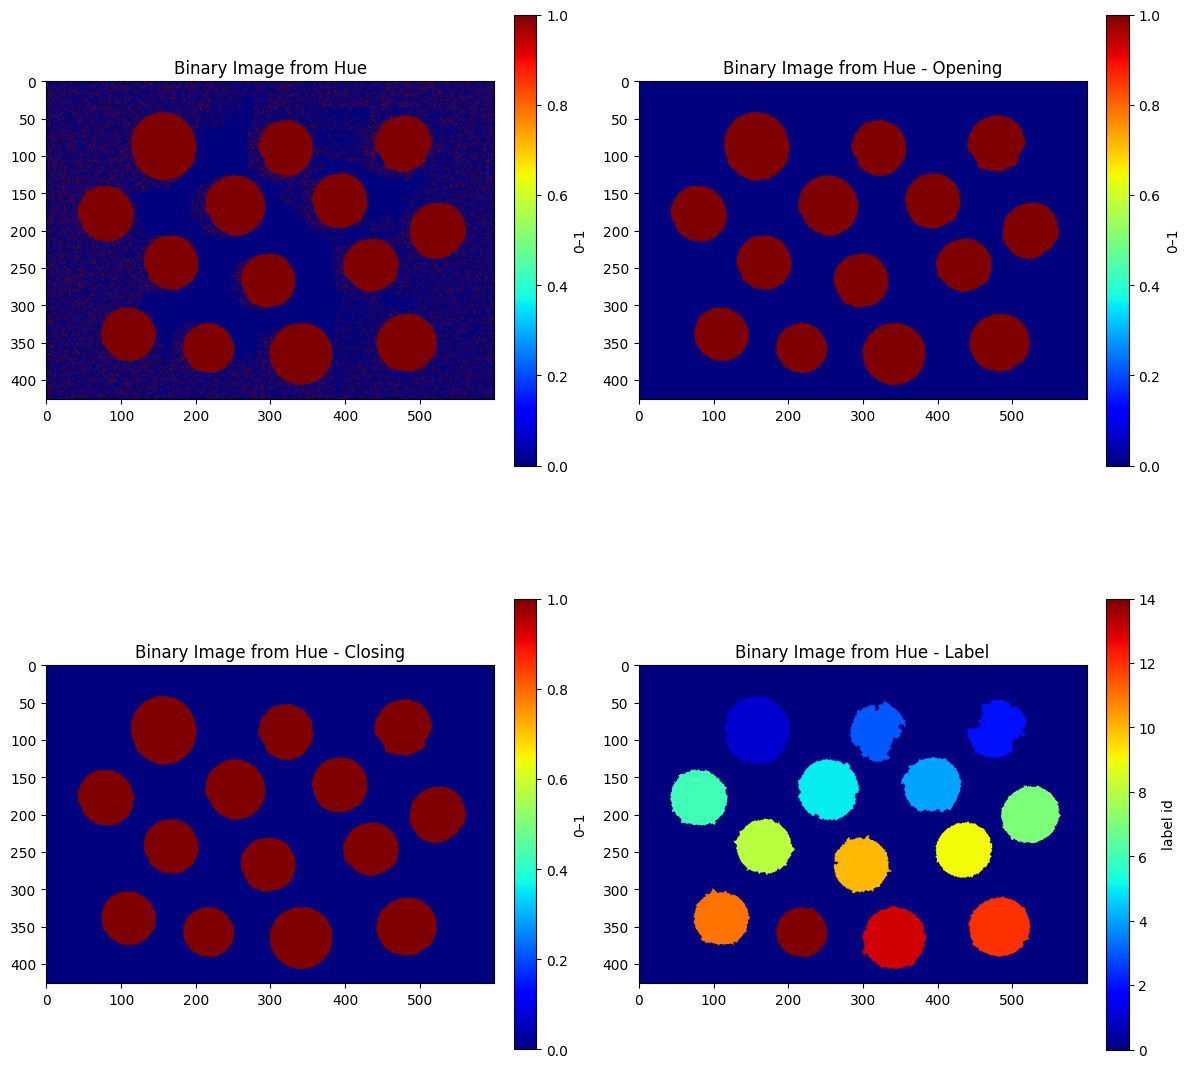

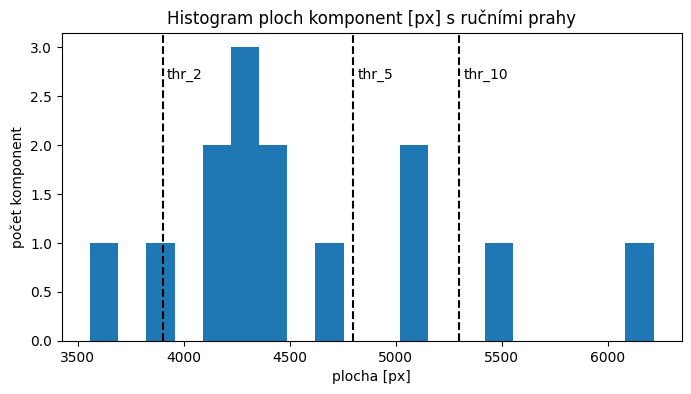

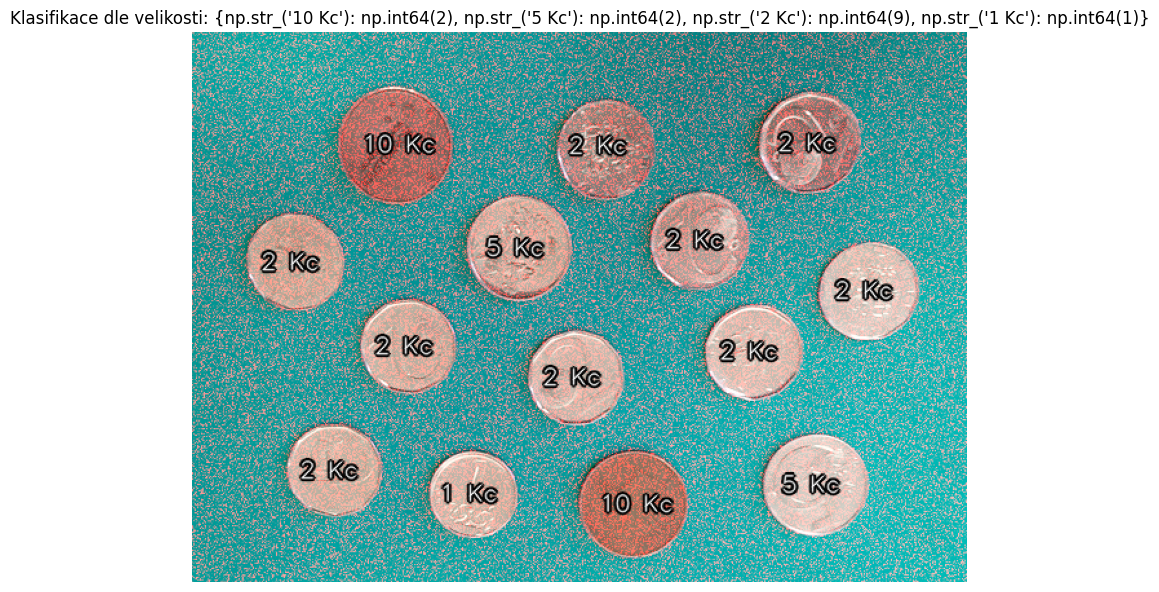

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from sklearn.cluster import KMeans  # not used for classification, fine to keep

IN_PATH = "./pvi_cv05_mince_noise.png"
OUT_DIR = "./out"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- load & conversions ----------
img_bgr = cv2.imread(IN_PATH, cv2.IMREAD_COLOR)
if img_bgr is None:
    raise RuntimeError(f"Cannot read {IN_PATH}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
hsv  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
hue  = hsv[:, :, 0]

# ---------- histograms ----------
hist_gray = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
hist_hue  = cv2.calcHist([hue],  [0], None, [180], [0, 180]).ravel()

# ---------- Otsu thresholds (keep numeric values) ----------
t_gray, bin_gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
t_hue,  bin_hue  = cv2.threshold(hue,  0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Otsu thresholds -> gray: {t_gray:.1f}, hue: {t_hue:.1f}")

# choose Hue segmentation (background teal vs coins)
seg = bin_hue.copy()
# ensure background is black and coins are white
border = np.hstack([seg[0,:], seg[-1,:], seg[:,0], seg[:,-1]])
if np.mean(border) > 127:
    seg = 255 - seg

# ---------- morphology (store intermediate opening/closing for EXTRA FIGURE) ----------
ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
BW_open_only  = cv2.morphologyEx(seg, cv2.MORPH_OPEN,  ker, iterations=1)
BW_close_only = cv2.morphologyEx(BW_open_only, cv2.MORPH_CLOSE, ker, iterations=2)

# ---------- split touching coins (watershed) ----------
# dist = cv2.distanceTransform(BW_close_only, cv2.DIST_L2, 5)
# _, sure_fg = cv2.threshold(dist, 0.45 * dist.max(), 255, 0)  # tweak if needed
# sure_fg = sure_fg.astype(np.uint8)
# sure_bg = cv2.dilate(BW_close_only, ker, iterations=2)
# unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers.astype(np.int32) + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img_rgb, markers)
BWop = np.uint8(markers > 1) * 255  # final clean binary mask (used for labeling)

# ---------- labeling ----------
BWlabel, ncc = ndi.label(BWop > 0)
print("Poč. komponent:", ncc)

# color labels image for display
rand_colors = np.random.RandomState(42).rand(ncc + 1, 3)
label_vis = (rand_colors[BWlabel] * 255).astype(np.uint8)

# ---------- areas & centroids + overlay with pixel counts ----------
labels    = np.arange(1, ncc + 1)
areas     = np.array([np.sum(BWlabel == lab) for lab in labels])  # <-- pixel count 'a'
centroids = np.array(ndi.center_of_mass(BWop > 0, BWlabel, labels))

overlay_counts = img_rgb.copy()
for (cy, cx), a in zip(centroids, areas):
    cv2.circle(overlay_counts, (int(cx), int(cy)), 3, (255, 0, 0), -1)  # centroid
    cv2.putText(overlay_counts, str(int(a)), (int(cx) - 28, int(cy) - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.55, (50, 50, 200), 2, cv2.LINE_AA)

# ---------- manual thresholds on areas ----------
thr_10 = 5300
thr_5  = 4800
thr_2  = 3900
print(f"Manual area thresholds: thr_2={thr_2}, thr_5={thr_5}, thr_10={thr_10}")

coin_names = []
for a in areas:
    if a >= thr_10:
        coin_names.append("10 Kc"); print(a, " 10")
    elif a >= thr_5:
        coin_names.append("5 Kc");  print(a, " 5")
    elif a >= thr_2:
        coin_names.append("2 Kc");  print(a, " 2")
    else:
        coin_names.append("1 Kc");  print(a, " 1")

u, cnt = np.unique(coin_names, return_counts=True)
class_counts = dict(sorted(zip(u, cnt),
                           key=lambda kv: ["10 Kc", "5 Kc", "2 Kc", "1 Kc"].index(kv[0])))
print("Počty mincí (klasifikace):", class_counts)

# draw classification labels
overlay_cls = img_rgb.copy()
for (cy, cx), name in zip(centroids, coin_names):
    cv2.putText(overlay_cls, name, (int(cx)-26, int(cy)+6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 3, cv2.LINE_AA)
    cv2.putText(overlay_cls, name, (int(cx)-26, int(cy)+6),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)

# ---------- helper to add colorbar ----------
def add_colorbar(im, ax, label=None):
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    if label:
        cbar.set_label(label)
    return cbar

# ---------- main 3×3 panel ----------
plt.figure(figsize=(14, 12))

ax = plt.subplot(3, 3, 1); im = ax.imshow(img_rgb); ax.set_title("Původní RGB"); ax.axis("off")

ax = plt.subplot(3, 3, 2); im = ax.imshow(gray, cmap="gray"); ax.set_title("Stupně šedi"); ax.axis("off")
add_colorbar(im, ax, "Intenzita [0–255]")

ax = plt.subplot(3, 3, 3); im = ax.imshow(hue, cmap="hsv"); ax.set_title("Složka Hue"); ax.axis("off")
add_colorbar(im, ax, "Hue [0–179]")

ax = plt.subplot(3, 3, 4); ax.plot(hist_gray); ax.set_title(f"Histogram šedi (Otsu={t_gray:.1f})")
ax.axvline(t_gray, ls="--", color="k")

ax = plt.subplot(3, 3, 5); ax.plot(hist_hue);  ax.set_title(f"Histogram Hue (Otsu={t_hue:.1f})")
ax.axvline(t_hue, ls="--", color="k")

ax = plt.subplot(3, 3, 6); im = ax.imshow(seg, cmap="gray"); ax.set_title("Segmentace (Otsu/Hue)"); ax.axis("off")
add_colorbar(im, ax, "0/255")

ax = plt.subplot(3, 3, 7); im = ax.imshow(BWop, cmap="gray"); ax.set_title("Po morfologii + watershed"); ax.axis("off")
add_colorbar(im, ax, "0/255")

ax = plt.subplot(3, 3, 8); ax.imshow(label_vis); ax.set_title(f"Barvení oblastí (n={ncc})"); ax.axis("off")

ax = plt.subplot(3, 3, 9); ax.imshow(overlay_counts); ax.set_title("Těžiště + počet pixelů"); ax.axis("off")

plt.figtext(0.5, 0.01,
            f"Manuální prahy ploch: thr_2={thr_2}, thr_5={thr_5}, thr_10={thr_10}",
            ha="center", va="bottom", fontsize=11)
plt.tight_layout(rect=[0, 0.03, 1, 1])
# closing opening hue
plt.figure(figsize=(12, 12))

# Left-top: Binary from Hue (raw)
ax = plt.subplot(2, 2, 1)
im = ax.imshow((seg/255).astype(float), cmap="jet", vmin=0, vmax=1)
ax.set_title("Binary Image from Hue"); ax.axis("on")
add_colorbar(im, ax, "0–1")

# Right-top: after Opening only
ax = plt.subplot(2, 2, 2)
im = ax.imshow((BW_open_only/255).astype(float), cmap="jet", vmin=0, vmax=1)
ax.set_title("Binary Image from Hue - Opening"); ax.axis("on")
add_colorbar(im, ax, "0–1")

# Left-bottom: after Closing only
ax = plt.subplot(2, 2, 3)
im = ax.imshow((BW_close_only/255).astype(float), cmap="jet", vmin=0, vmax=1)
ax.set_title("Binary Image from Hue - Closing"); ax.axis("on")
add_colorbar(im, ax, "0–1")

# Right-bottom: label map (IDs)
ax = plt.subplot(2, 2, 4)
im = ax.imshow(BWlabel, cmap="jet")
ax.set_title("Binary Image from Hue - Label"); ax.axis("on")
cbar = add_colorbar(im, ax, "label id")

plt.tight_layout()

# ---------- histogram of areas with manual thresholds (for reference) ----------
plt.figure(figsize=(8, 4))
plt.hist(areas, bins=20)
for v, txt in [(thr_2, "thr_2"), (thr_5, "thr_5"), (thr_10, "thr_10")]:
    plt.axvline(v, ls="--", color="k"); plt.text(v + 20, plt.ylim()[1]*0.85, txt)
plt.title("Histogram ploch komponent [px] s ručními prahy")
plt.xlabel("plocha [px]"); plt.ylabel("počet komponent")

# ---------- final classification overlay ----------
plt.figure(figsize=(10, 8))
plt.imshow(overlay_cls); plt.axis("off")
plt.title(f"Klasifikace dle velikosti: {class_counts}")

plt.show()
